Atonia Andall
816009278

In [1]:
import pandas as pd
import numpy as np

### Warm Up

In [2]:
def vectorRep(arr):
    result=[]
    for string in arr:
        string=string.lower()
        result.append([string.count("apple"), string.count("banana"), string.count("orange")])
    return np.reshape(result, (-1,3))  

In [3]:
corpus = ['Apple Orange Orange Apple', 'Apple Banana Apple Banana', 'Banana Apple Banana Banana Banana Apple',  'Banana Orange Banana Banana Orange Banana', 'Banana Apple Banana Banana Orange Banana']  
print(vectorRep(corpus))

[[2 0 2]
 [2 2 0]
 [2 4 0]
 [0 4 2]
 [1 4 1]]


### Preprocessing and Data Organization

In [4]:
from sklearn.utils import shuffle

In [5]:
df=pd.read_csv('MrTrumpSpeeches.csv', header=0, sep="\~", engine='python')
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.582491,266.0,31.0,we welcome stars and president [Music] ...
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.924731,365.0,7.0,you thank you [Music] great people Gr...


In [6]:
pos = df[df['like_count']>df['dislike_count']]
neg = df[df['like_count']<df['dislike_count']]
net = df[df['like_count']==df['dislike_count']]
print(pos.shape, neg.shape, net.shape)
print(df["average_rating"].describe())

(763, 9) (66, 9) (7, 9)
count    836.000000
mean       4.345376
std        0.702294
min        1.347826
25%        4.263935
50%        4.589107
75%        4.782065
max        5.000000
Name: average_rating, dtype: float64


We will use like and dislike count to determine sentiment.  Since there is so few neutral counts and the assignment only specified for positive and negative sentiment, we will classify neutral sentiments as positive sentiments.

In [7]:
df.loc[df["like_count"]>=df["dislike_count"], "sentiment"] =1
df.loc[df["like_count"]<df["dislike_count"], "sentiment"] =0

df.describe()

,upload_date,view_count,average_rating,like_count,dislike_count,sentiment
count,8.360000e+02,8.360000e+02,836.000000,836.000000,836.000000,836.000000
mean,2.016526e+07,2.478265e+04,4.345376,288.478469,56.348086,0.921053
std,4.783116e+03,6.020921e+04,0.702294,498.063763,188.722867,0.269818
min,2.016020e+07,7.100000e+01,1.347826,2.000000,0.000000,0.000000
25%,2.016081e+07,1.788000e+03,4.263935,29.000000,4.000000,1.000000
50%,2.016110e+07,8.775500e+03,4.589107,122.000000,19.000000,1.000000
75%,2.017031e+07,2.270900e+04,4.782065,358.250000,47.000000,1.000000
max,2.017080e+07,1.013054e+06,5.000000,6143.000000,3544.000000,1.000000


In [8]:
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

In cleaning the subtitle data, let's first see what it contains

In [9]:
df["subtitles"].head()

0       presidents of the United States mr. go   tr...
1       it's now officially Tuesday November a   di...
2       you   [Music]   [Music]   [Music]   you   I...
3       we welcome stars and president   [Music]   ...
4       you   thank you   [Music]   great people Gr...
Name: subtitles, dtype: object

The data contains words in brackets depicting background things such as music or applause.  we should remove those words as they are not part of the speech

In [10]:
tokens = df["subtitles"].apply(lambda x: re.sub("\\[.*?]", "", x))

We can now split the all our transcripts into tokens

In [11]:
tokens = tokens.apply(lambda x:word_tokenize(x))

Having this individual tokens, we can now remove punctuations and put the words to lover case

In [12]:
tokens = tokens.apply(lambda instance: [word.lower() for word in instance if word.isalpha()]  )

In [13]:
tokens.head()

0    [presidents, of, the, united, states, go, trap...
1    [it, now, officially, tuesday, november, a, di...
2    [you, you, i, you, the, greatness, of, our, co...
3    [we, welcome, stars, and, president, all, over...
4    [you, thank, you, great, people, granna, befor...
Name: subtitles, dtype: object

We can remove common words within the english language now.  since the words have been split based on punctuations, it will also remove some stray characters

In [14]:
stop_words = set(stopwords.words('english'))
tokens = tokens.apply(lambda instance: [word for word in instance if not word in stop_words]  )

The final step we will take is reducing all words to their base.  In order for the resultant words to make more sense, we will use a lemmaizer and lemmatize in regards to verbs.

In [15]:
# porter = PorterStemmer()
# tokens = tokens.apply(lambda instance:[porter.stem(word) for word in instance])

lemmatizer = WordNetLemmatizer()
tokens = tokens.apply(lambda instance:[lemmatizer.lemmatize(word, pos="v") for word in instance])

In [16]:
df["subtitle_clean"]=tokens.apply(lambda instance: " ".join(instance))

In [17]:
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment,subtitle_clean
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...,1.0,presidents unite state go trapp family thank e...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...,1.0,officially tuesday november ever think hear ma...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...,1.0,greatness country leader free unfree world van...
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.582491,266.0,31.0,we welcome stars and president [Music] ...,1.0,welcome star president place live place wow gr...
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.924731,365.0,7.0,you thank you [Music] great people Gr...,1.0,thank great people granna three days go win gr...


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
cv = CountVectorizer(stop_words = 'english')
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

In [20]:
cv_vec=cv.fit_transform(df["subtitle_clean"])
tf_vec=tfidf.fit_transform(df["subtitle_clean"])
tf_n_vec= tfidf_n.fit_transform(df["subtitle_clean"])

In [21]:
y=df["sentiment"]

### Text Classification

In [22]:
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Frequency')

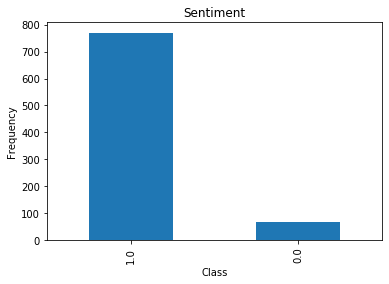

In [23]:
y.value_counts().plot(kind = 'bar')
plt.title("Sentiment")
plt.xlabel("Class")
plt.ylabel("Frequency")

The majority of this data is classified in the positive class.  Since the data is inbalanced, accuracy may not be the best metric.  Since the majority class is positive, the model is more likely to correctly predict an entity belonging to the positive class than to the negative class.  Because of this, recall would not be a good metric as it may show the model is doing better than it actually is. Precision is the ability of a classifier not to label as positive a sample that is negative and would be an appropriate metric here.

In [24]:
names=[]
scores=[]
def text_train(y, fitted, model ,name, names, scores):
    print("Results for ", name)
    X_train, X_test, y_train, y_test = train_test_split(fitted, y, random_state=0)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test,y_pred)*100
    print(confusion_matrix(y_test, y_pred))
    print ('Model Precision: {}'.format(precision))
    names.append(name)
    scores.append(precision)

#### Logistic Regression

In [25]:
text_train(y, cv_vec, LogisticRegression(solver='lbfgs', max_iter=2000), "Count Vectorizer LR", names, scores )

Results for  Count Vectorizer LR
[[  1  14]
 [  3 191]]
Model Precision: 93.17073170731707


In [26]:
text_train(y, tf_vec,LogisticRegression(solver='lbfgs', max_iter=2000), "TFID Vectorizer LR", names, scores )

Results for  TFID Vectorizer LR
[[  0  15]
 [  0 194]]
Model Precision: 92.82296650717703


In [27]:
text_train(y, tf_n_vec,LogisticRegression(solver='lbfgs', max_iter=2000), "TFID Vectorizer + ngram LR", names, scores  )

Results for  TFID Vectorizer + ngram LR
[[  0  15]
 [  0 194]]
Model Precision: 92.82296650717703


#### Support Vector Machine

In [28]:
text_train(y, cv_vec, LinearSVC(), "Count Vectorizer SVM",names, scores )

Results for  Count Vectorizer SVM
[[  2  13]
 [  9 185]]
Model Precision: 93.43434343434343


In [29]:
sv_tf=text_train(y, tf_vec, LinearSVC(), "TFID Vectorizer SVM",names, scores  )

Results for  TFID Vectorizer SVM
[[  0  15]
 [  0 194]]
Model Precision: 92.82296650717703


In [30]:
text_train(y, tf_n_vec, LinearSVC(), "TFID Vectorizer + ngram SVM", names, scores )

Results for  TFID Vectorizer + ngram SVM
[[  0  15]
 [  0 194]]
Model Precision: 92.82296650717703


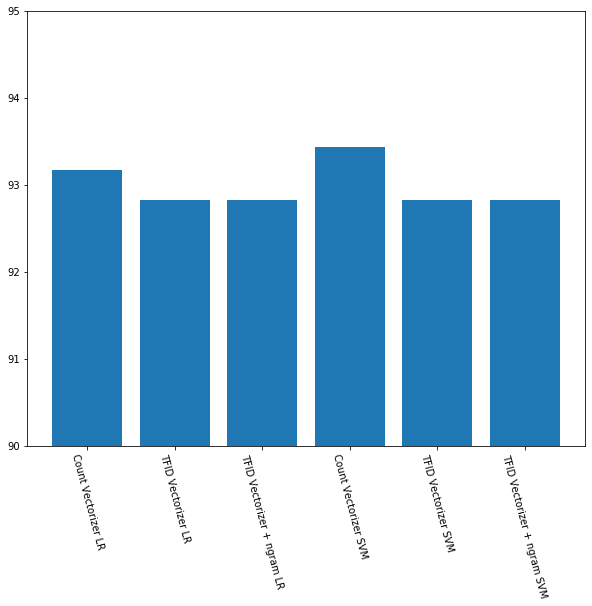

In [31]:
plt.figure(figsize=(10,8))
plt.bar(names, scores)
plt.xticks(rotation=-75)
plt.ylim(90, 95)
plt.show()

### Topic Modelling

In [32]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [33]:
def display_topics(H, W, feature_names, documents, no_top_words):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#         print("\n")
#         top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print(documents[doc_index])
#             print("\n")

In [34]:
documents = list(df["subtitle_clean"])[0:1000]
print(len(documents))

836


In [35]:
cv = CountVectorizer(stop_words = 'english')

cv_vec=cv.fit_transform(documents)
tf_vec=tfidf.fit_transform(documents)

tf_feature_names=tfidf.get_feature_names()
cv_feature_names=cv.get_feature_names()

The number of topics chosen cannot be too large as the model would take a long time to converge in that case.  While considering this, we try to get the number of topics that give the most coherent results.  Metrics such as coherence score may be used.  In this case, we used trial and error to get the best number of topics.  LDA uses less topics as topics start to repeat and get less coherent as the number of topics increases.  Icreasing number of iterations diversified to topics but made it less coherent.  LDA performed the worst in regards to topic modelling

In [36]:
num_topics=10
num_top_words = 10
num_top_documents = 10

In [37]:
#NMF
nmf_model = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf_vec)
nmf_W = nmf_model.transform(tf_vec)
nmf_H = nmf_model.components_

In [73]:
#LDA
lda_model = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(cv_vec)
lda_W = lda_model.transform(cv_vec)
lda_H = lda_model.components_

In [39]:
#SVD
lsi_model = TruncatedSVD(n_components=num_topics, n_iter=7, random_state=42).fit(cv_vec)
lsi_W = lsi_model.transform(cv_vec)
lsi_H = lsi_model.components_

In [40]:
print("NMF Topics TF")
print("=========================================================================== \n")
display_topics(nmf_H, nmf_W, tf_feature_names, documents, num_top_words)

NMF Topics

Topic 0:
say know people want like think great right win look
Topic 1:
clinton hillary country job people american america make state tax
Topic 2:
click watch exclusives highlight digital channel latest button youtube videos
Topic 3:
thank great america god people nation want country american president
Topic 4:
donald trump america know president state unite clinton need let
Topic 5:
president house trump white flynn intelligence russian say report administration
Topic 6:
israel peace minister state prime nato unite ally region president
Topic 7:
american job workers energy new tax america make trade company
Topic 8:
health obamacare care insurance plan cost repeal americans premiums work
Topic 9:
navy gerald ship aircraft admiral midway ford uss newport fleet


Topic 0:  Discussing public opinions on himself (Donald Trump)

Topic 1:  Trump talking about his opponent, Hillary Clinton, and their different values in taxation and keeping jobs in America.

Topic 2:  Likely promotional media from where the speech videos were hosted such as a subscribing to a particular Youtube channel.

Topic 3:  Patriotic American sentiments

Topic 4:  Promoting Donald Trump as opposed to Hillary Clinton for president

Topic 5:  Talking about the scandal of security advisor Micheal Flynn associating with Russian Intelligence

Topic 6:  Talking about military allies (NATO) and US-Isreal rlations

Topic 7:  Jobs and taxation in America

Topic 8: Repealing Obamacare

Topic 9: Discussing the American military power

In [74]:
print("LDA Topics")
print("=========================================================================== \n")
display_topics(lda_H, lda_W, cv_feature_names, documents, num_top_words)


LDA Topics

Topic 0:
people say know want like make country great job state
Topic 1:
say know people want like great right think come make
Topic 2:
people know thank president state say unite make want job
Topic 3:
people say know country want make great job thank right
Topic 4:
say people know country want like great make think tell


Topic 0: Creating jobs in America

Topic 1:  Coming to make America great

Topic 2: The people of the United States thank the president for jobs

Topic 3:  The people of the United States thank the president for jobs

Topic 4: Creating jobs.  Positive sentiment of people 

In [42]:
print("\n\nLSI Topics")
print("=========================================================================== \n")
display_topics(lsi_H, lsi_W, cv_feature_names, documents, num_top_words)



LSI Topics

Topic 0:
say know people want great like right think make country
Topic 1:
american country america job clinton state thank hillary president make
Topic 2:
president thank think trump unite know state today really donald
Topic 3:
trump hillary say clinton donald think state president obama russia
Topic 4:
think deal job trade china dollars new money company look
Topic 5:
people think know hillary clinton look lot want mean question
Topic 6:
know right china clinton hillary tax job trade build donald
Topic 7:
gon na say thank tax great american right million energy
Topic 8:
na gon think time happen president administration government question country
Topic 9:
trump donald na gon people new job look win american


Topic 0:  Make America great

Topic 1:  The president creating American jobs and Hillary Clinton

Topic 2: Thanking Trump for what he has done for the United States 

Topic 3: Past president Obama and presidential candiate Hillary and ties to Russia

Topic 4:  Making a deal with China to get money

Topic 5:  Discussing how Hillary Clinton appears to the public

Topic 6:  Discussing Trump from Hilliary Clinton's views on tax, jobs and or in China

Topic 7: American energy taxes.

Topic 8: Opinion on the country questioning the goverment

Topic 9:  Donald Trump creating jobs in America

### Visualization

In [78]:
def print_cloud(data):
    wordcloud = WordCloud(
              background_color='white',
              max_words=200,
              max_font_size=40, 
              random_state=42
             ).generate(str(data))
    
    return wordcloud

In [79]:
plt.rcParams['font.size']=12                 
plt.rcParams['savefig.dpi']=100             
plt.rcParams['figure.subplot.bottom']=.1

In [76]:
from wordcloud import WordCloud, STOPWORDS

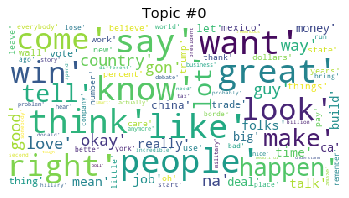

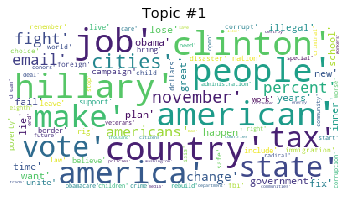

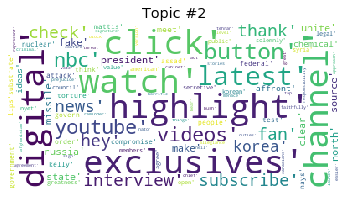

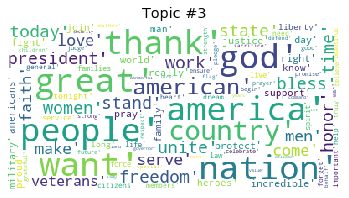

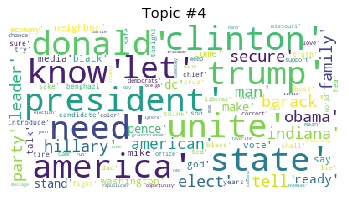

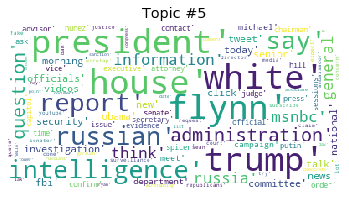

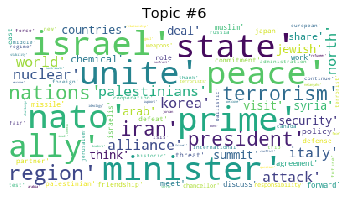

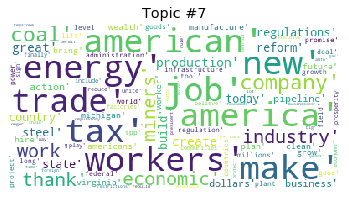

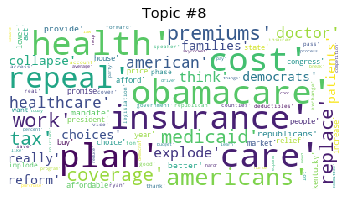

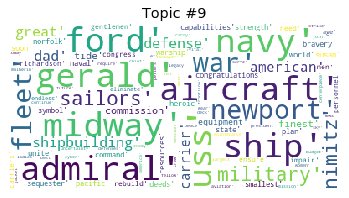

In [140]:
#NMF


for t in range (0, num_topics):
    top_indexes= nmf_H[t].argsort()[:-100 - 1:-1]
    data=[]
    for x in top_indexes:
        data.append(tf_feature_names[x])
        
    word_cloud=print_cloud(data)
    plt.figure()
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


    

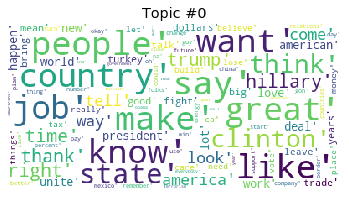

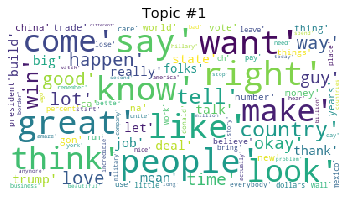

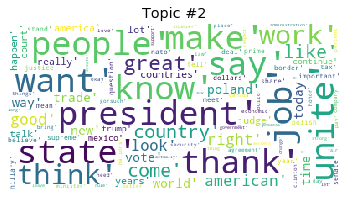

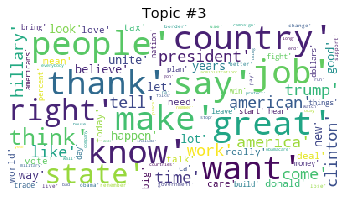

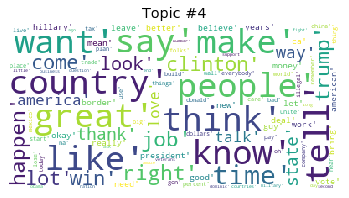

In [138]:
#LDA


for t in range (0, 5):
    top_indexes= lda_H[t].argsort()[:-100 - 1:-1]
    data=[]
    for x in top_indexes:
        data.append(cv_feature_names[x])
    word_cloud=print_cloud(data)
    plt.figure()
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


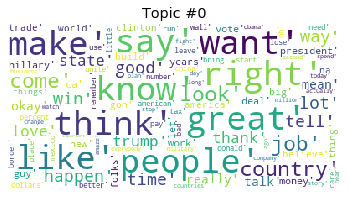

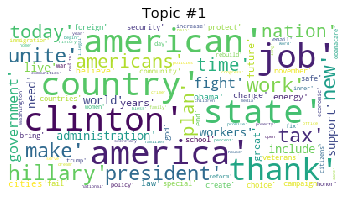

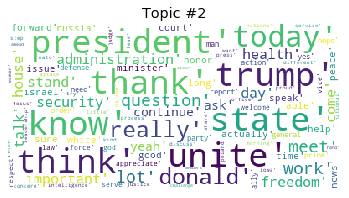

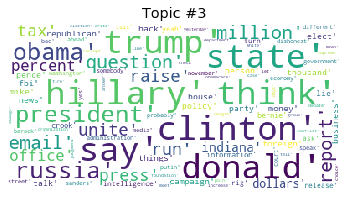

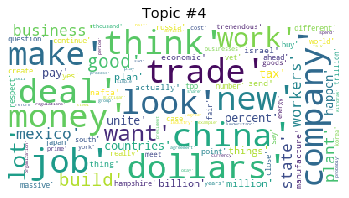

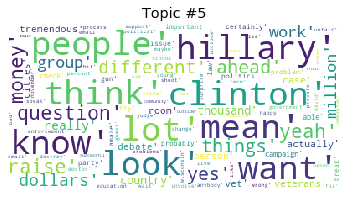

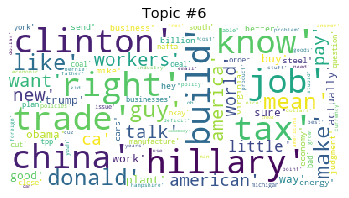

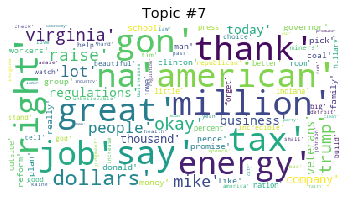

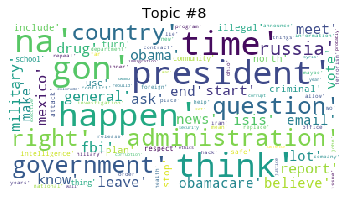

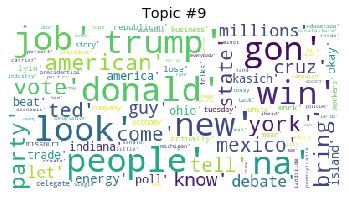

In [141]:
#LSI


for t in range (0, num_topics):
    top_indexes= lsi_H[t].argsort()[:-100 - 1:-1]
    data=[]
    for x in top_indexes:
        data.append(tf_feature_names[x])
        
    word_cloud=print_cloud(data)
    plt.figure()
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()